# 3D fuel mapping for forest fire risk assessment

### Purpose

The objetive of this tutorial is to explain the Experiment 2 of the GeoSpatial use case in the H2020 CloudButton project. The main goal of the project is to create a Serverless Data Analytics Platform that aims to “democratize big data” by overly simplifying the overall life cycle and programming model thanks to serverless technologies. The idea is to tap into stateless functions to enable radically-simpler, more user-friendly data processing systems. The CloudButton platform will seamlessly integrate a Serverless Compute Engine, a Mutable Shared Data Middleware, and new Serverless Cloud Programming Abstractions on top.

The seconed experiment is based in a high-resolution forest fuel mapping. We will generate a fuel map of the Valencian Community in Spain, which include protected areas, using remote sensing fusion techniques and following an object-based classification model. 3D LiDAR-derived metrics of shrub and tree canopy structure of two dates (reference years) will be used as input data in spatial fire risk modelling, that also benefits of high resolution elevation models and other topographic input variables. The expected result is a high-resolution forest fire risk map that is useful for decision-making in forest planning and management. Also, we will make a performance comparison assessment of results obtained through CloudButton toolkit and conventional software and computer facilities.

### 1. Setup


#### 1.1. Set up docker

To work with all the libraries in a **jupyter notebook** we will run a **docker** built for the experiment. It is necesarry to download <a href="https://www.docker.com/products/docker-desktop">docker desktop</a>, once it is done, we download and run the image of the docker that its gonna be used.

> docker pull mavsonnen/jupy-notebook:geosv2<br>
> docker run mavsonnen/jupy-notebook:geosv2

A **local directory** can be connected to a docker container creating a volume using <i>-v option</i>, change <i>local_path</i>:

> docker run -p 8888:8888 -v E:/cloudbutton:/home/jovyan/work mavsonnen/jupy-notebook:geosv2




#### 1.2. Importing libraries

The following libraries are necessary:

In [1]:
pip install -U lithops

     |████████████████████████████████| 308 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 219 kB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 7.9 MB/s  eta 0:00:01
  Using cached docutils-0.15.2-py3-none-any.whl (547 kB)
  Created wheel for ps-mem: filename=ps_mem-3.12-py3-none-any.whl size=18876 sha256=9ea0e08d5aa7ea825c81cc1af8a0b9c3e3b91237ed36fc7d6755a1bf600454eb
  Stored in directory: /home/jovyan/.cache/pip/wheels/67/df/f3/b96d8ddc3b63908ffed6e737db4dcbdd1819d5ddf17a183bf5
  Created wheel for ibm-vpc: filename=ibm_vpc-0.8.0-py3-none-any.whl size=224787 sha256=d078a626020d6997e4adfe35e29c7df0ae374a9244b7e8ad55565adbc7fdf5ce
  Stored in directory: /home/jovyan/.cache/pip/wheels/3a/77/97/8237b030db9a7860badcc1f7e98c63c6470f6ab4989530c128
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-3.13.2-py3-none-any.whl size=83233 sha256=51a8132530a0b3f9bb192cf06d1ac68b73c3d16031067afcf633e753542fdc56
  Stored in directory: /home/jovy

In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale,StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans 
from shapely.geometry import mapping
from IPython.display import Image
from IPython.core.display import HTML 
from shapely.geometry import mapping
import rasterio as rio
from sklearn.pipeline import Pipeline
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import lithops
import shapely
import shutil
import pickle
import joblib
import gdal
import earthpy as ep
import earthpy.spatial as es
import time
import glob
import ogr
import os
import io
import pdal
#import rioxarray as rxr
import xarray as xr
import json
from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

print("Libraries imported succesfully")

Libraries imported succesfully


#### 1.3. Configuration lithops

We have reached the serverless implementation thanks to the framework **lithops**.
All files that are going to run it will be on local.

![Image of Yaktocat](https://github.com/lithops-cloud/lithops/blob/master/docs/images/lithops_flat_cloud_1.png?raw=true)

Working with lithops require a configuration file like the one express below. More info can be found in the official **<a href="https://github.com/lithops-cloud/lithops">github</a> of Lithops**. 

 <i>
    {"serverless": {"backend": "BACKEND"},
         
          "ibm":  {"iam_api_key": "IAM_API_KEY"},
         
          "ibm_cf":  {"endpoint": "ENDPOINT",
                      "namespace": "NAMESPACE",
                      "namespace_id": "NAMESPACE_ID"},
         
          "ibm_cos": {"endpoint": "ENDPOINT",
                      "private_endpoint": "PRIVATE_ENDPOINT",
                      "region" : "REGION",
                      "api_key" : "API_KEY"},
         
          "lithops": {"storage_bucket" : "STORAGE_BUCKET"}}

The **config** file with all the parameters is uploaded below

In [2]:
config_path = open("config.txt")
config_read = config_path.read()
config = json.loads(config_read)

#### 1.4. Downloading images

The LiDAR data has been obtained from the Spanish National Geographic Institute of the PNOA (National Plan of Aerial Orthophotography) <a href="http://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=LIDAR">link</a>. 

1- Selecet LIDAR 2ª Cobertura (2015-Actualidad).

2- Select valencian community from top left.

3- Choose which data year we want to download. 

### 2. Dataset processing

#### 2.1 Remove noise data and create DEM (Digital Elevation Model)

The first step in Point cloud data is removing noise points. The filter used was the Radius Outlier Removal filter (ROR) due to its good results compared to other filters.


A Digital Elevation Model (DEM) or Digital Terrain Model (DTM) is a representation of the bare ground (bare earth) topographic surface of the Earth excluding trees, buildings, and any other surface objects. 

In this case we want to ignore any LiDAR classification values that may have already been calculated so that we can derive our own. In this example we apply a value of 0 (not classified) to the Classification dimension for every point.


The PDAL (Point Data Abstraction Library) is a very powerful tool for processing LiDAR point cloud data and very adept at extracting surface models based on point classification and filtering algorithms.

PDAL allows the composition of operations on point clouds into ‘pipelines’. These pipelines are written in the JSON format and define each step for the processing of the data in a sequence. This leads itself to highly customisable point cloud processing, that is repeatable and runs many steps in one execution of the program.



Define dem_extract function  that read lidar images (laz extension), then remove noise data, extract DEM and save the new image as tif extension.

#### 2.2  Remove noise data and Create DSM (Digital Surface Model)


Digital Surface Model (DSM) represents the top of the earth’s surface. It includes TREES, BUILDINGS and other objects that sit on the earth.

To Extract DSM we will write dsm_extract function that has pipeline composed for extracting the DSM from the cleaned LiDAR point cloud.

In this case we want to ignore any LiDAR classification values that may have already been calculated so that we can derive our own. In this example we apply a value of 0 (not classified) to the Classification dimension for every point.



Any time we have points classified as ground, we may wish to extract just these points, e.g., to create a digital terrain model (DTM). In this case, we use a range filter as shown.



Create neccesary folders to save lidars.Then, save lidar in temporary folder


#### 2.3  Create CHM (Canopy Height Model)

The height or residual distance between the ground and the top of the of objects above the ground. This includes the actual heights of trees, builds and any other objects on the earth’s surface. This CHM is created by subtracting the DTM from the DSM.


Once the DSM and DTM models have are computed, GDAL can be used to run a raster calculator to output the CHM.



## Topography characteristics

Topography Landscape topography has an impact on the environmental conditions, the amount of certain types  of  vegetation,  and  therefore,  has  a  direct  influence  upon  fire  propagation.  In  the following,  we  focus  on  the  aspect,  slope  and  elevation  that  are  input  variables  of  fire  spread models and that can be retrieved using LiDAR.  

a) Aspect: the aspect is the direction a slope is facing. The solar orientation generally determines the amount of heat provided by the Sun and therefore has high influence on  the  amount,  condition  and  type  of  fuels.  South-southwest  slopes  are  more  exposed  to sunlight  and  often  correspond  to  lighter  and  sparser  fuels,  higher  temperatures,  lower humidity  and  lower  fuel  moisture.  They  consequently  are  most  critical  in  terms  of  start  and spread of wildland fires. On the contrary, north-facing slopes are less subjected to fire activity than  south-facing  slopes.  They  are  more  shaded,  which  leads  to  heavier  fuels,  lower temperature, higher humidity and higher fuel moisture. North-facing vs south-facing slopes.  
 

b) Slope: it is the degree of incline of a hill side. The steeper  the slope, the faster  the  fire  spreads,  and  it  burns  more  rapidly uphill  than  downhill.  An explanation  for  these  two  phenomena  is  that  the  fuel  above  the  fire  is  brought  into  closer contact with the upward moving flames. Another concern about steep slopes is the possibility that burning materials roll down the hill and ignite the fuel below the main fire. A  surface  fire  is  primarily  influenced  by  the  amount  of  fuel  and  the  wind  speed,  but  a  fire starting near the bottom of a slope in normal daytime upslope wind conditions should spread faster and over a larger area than a fire starting near the top of the slope. 

We create calculation function that receive lidar photo that exist in IBM cloud. Then,  the function does the steps that we explained it above (DEM, DSM, CHM, Aspect and Slope).

In [3]:
def calculation(obj, ibm_cos):
    
    # Define locations 
    key = obj.key
    bucket_name = 'ziad-cloudbutton'
    loc_dsm = 'dsm/'
    loc_dem = 'dem/'
    loc_chm = 'chm/'
    loc_aspect = 'aspect/'
    loc_slope = 'slope/'
    input_folder = "input_folder/"
    loc_fcc= 'fcc/'
    #-----------------------------------------------------------------------------------
    # Create dsm, dem, chm, slope, aspect, and input folders to save the photos after doing process

    if not os.path.exists(input_folder):
        os.mkdir(input_folder)
      
    if not os.path.exists(loc_dsm):
        os.mkdir(loc_dsm)
    
    if not os.path.exists(loc_dem):
        os.mkdir(loc_dem)
    
    if not os.path.exists(loc_chm):
        os.mkdir(loc_chm)
        
    if not os.path.exists(loc_aspect):
        os.mkdir(loc_aspect)
        
    if not os.path.exists(loc_slope):
        os.mkdir(loc_slope)
        
    if not os.path.exists(loc_fcc):
        os.mkdir(loc_fcc)
        
   #-----------------------------------------------------------------------------------
   # Delete any file in dsm, dem, chm, slope, aspect, and input folders

    files = os.listdir(loc_dsm)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_dsm, file)
            os.unlink(file_path)
            
    files = os.listdir(loc_dem)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_dem, file)
            os.unlink(file_path)
            
    files = os.listdir(loc_chm)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_chm, file)
            os.unlink(file_path)
            
    files = os.listdir(loc_slope)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_slope, file)
            os.unlink(file_path)
            
    files = os.listdir(loc_aspect)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_aspect, file)
            os.unlink(file_path)
            
    files = os.listdir(loc_fcc)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_fcc, file)
            os.unlink(file_path)
            
    files = os.listdir(input_folder)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(input_folder, file)
            #os.rmdir('input_folder/laz/')

            os.unlink(file_path)

    # -----------------------------------------------------------------------------------      
    # We interested just in laz photos
    if '.laz' in key:
       


        # Read data stream of object
        data = obj.data_stream.read()   
        
        # Save data into file 
        key = key [4:]
        s_file = input_folder + key
        with open(s_file, 'wb') as fname:
            fname.write(data)

        # -----------------------------------------------------------------------------------  
        # define variables name 
       
        lasfile = fname.name
        filez =key.split(".")[0]
        outputfile_dsm = loc_dsm +  f"dsm_{filez}.tif"
        outputfile_dem = loc_dem +  f"dem_{filez}.tif"

        inputfiles_dem = f"dem/dem_{filez}.tif"
        inputfiles_dsm = f"dsm/dsm_{filez}.tif"
        outputfile_chm = f"chm/chm_{filez}.tif"
        outputfile_aspect = f"aspect/aspect_{filez}.tif"
        outputfile_slope =  f"slope/slope_{filez}.tif"
        outputfile_fcc =  f"fcc/fcc_{filez}.tif"

        # -----------------------------------------------------------------------------------  
        # calculate DSM
        creating_json = {
                "pipeline": [
                {
                        "type": "readers.las",
                        "filename": f"{lasfile}",
                        "spatialreference": "EPSG:25830"
                },
                {

                        "type":"filters.reprojection",

                        "in_srs":"EPSG:25830",

                        "out_srs":"EPSG:25830"

                },
                {
                        "type":"filters.outlier",
                        "method":"radius",
                        "radius":1.0,
                        "min_k":4
                },
                {
                        "type":"filters.range",
                        "limits":"Classification![7:7]"  # Classification equals 2 (corresponding to noise points in LAS).
                },
                {
                        "type":"filters.range",
                        "limits":"returnnumber[1:1]"

                },


                {
                        "type": "writers.gdal",
                        "gdaldriver": "GTiff",
                        "nodata": "-9999",
                        "output_type": "max",
                        "resolution": 1, 
                        "filename": f"{outputfile_dsm}"
                }
                
                ]
        }
        consulta = json.dumps(creating_json, indent = 4)
        pipeline = pdal.Pipeline(consulta)
        pipeline.validate()  # Check if json options are good
        pipeline.loglevel = 8
        count = pipeline.execute()    
        
        # calcualte DEM
        creating_json = {
                    "pipeline": [

                    {
                            "type": "readers.las",
                            "filename": f"{lasfile}",
                            "spatialreference": "EPSG:25830"
                    },


                    {
                            "type":"filters.reprojection",
                            "in_srs":"EPSG:25830",
                            "out_srs":"EPSG:25830"
                    },


                    {
                          "type":"filters.assign",
                          "assignment":"Classification[:]=0"
                    },


                     {
                              "type":"filters.elm"
                    },

                    {
                            "type":"filters.outlier",
                            "method":"radius",
                            "radius":1.0,
                            "min_k":4
                    },
                    {

                          "type":"filters.smrf",
                          "ignore":"Classification[7:7]",
                          "slope":0.2,
                          "window":16,
                          "threshold":0.45,
                          "scalar":1.2
                    },

                    {
                            "type": "filters.range",
                            "limits": "Classification[2:2]", # Classification equals 2 (corresponding to ground in LAS).



                    },


                    {
                            "type": "writers.gdal",
                            "gdaldriver": "GTiff",
                            "nodata": "-9999",
                            "output_type": "max",
                            "resolution": 1, 
                            "filename": f"{outputfile_dem}"
                    }

                    ]
            }
        consulta = json.dumps(creating_json, indent = 4)
        pipeline = pdal.Pipeline(consulta)
        pipeline.validate()  # Check if json options are good
        pipeline.loglevel = 8
        count = pipeline.execute()  
        
        # calculate CHM
        command = 'gdal_calc.py -A {0} -B {1}   --calc="B-A" --NoDataValue=0  --outfile {2}'.format(inputfiles_dem,inputfiles_dsm, outputfile_chm)
        os.system(command)
        
        # calculate aspect
        command = 'gdaldem  aspect {0}  {1} -compute_edges'.format(inputfiles_dem,outputfile_aspect)
        os.system(command)
        
        # calculate slope
        command = 'gdaldem  slope {0}  {1} -compute_edges'.format(inputfiles_dem,outputfile_slope)
        os.system(command)
   

        from osgeo import gdal
        from osgeo import osr
        from scipy import ndimage
        import numpy as np


        def compute_fraction(array):
            nveg = np.sum(array == 1)
            total = len(array)
            out = (nveg/total)*100
            return(out)


        def FCC(image, output, window = 3, breakpoint = 0.01):
            # Reading data needed
            tch = image
            in_ds = gdal.Open(tch)
            rows = in_ds.RasterYSize
            cols = in_ds.RasterXSize
            in_band = in_ds.GetRasterBand(1)
            data = in_band.ReadAsArray(0, 0, cols, rows).astype(np.float)

            # Reclassifying data
            data[data > breakpoint] = 1
            data[data <= breakpoint] = 0

            # Computing fraction on the whole raster through a moving window.
            TCC = ndimage.generic_filter(data, compute_fraction, size = window)

            # Setting output
            gtiff_driver = gdal.GetDriverByName("GTiff")
            out_ds = gtiff_driver.Create(output, cols, rows, 1, in_band.DataType)
            out_ds.SetProjection(in_ds.GetProjection())
            out_ds.SetGeoTransform(in_ds.GetGeoTransform())

            # Writing data
            out_band = out_ds.GetRasterBand(1)
            out_band.WriteArray(TCC)
            # out_ds.BuildOverviews("Average", [2, 4, 8, 16, 32])

            out_ds.FlushCache()

            del in_ds, out_ds

        

        
        #Upload files into COS
        
        #Upload DEM
        for r, d, f in os.walk(loc_dem): # r=root, d=directories, f = files
            for file in f:
                FCC(image = loc_dem + file, output = outputfile_fcc, window = 20, breakpoint = 0.2)

                ibm_cos.upload_file(Filename = loc_dem + file, Bucket = bucket_name, Key =  loc_dem + file)
                
        #Upload DSM
        for r, d, f in os.walk(loc_dsm): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_dsm + file, Bucket = bucket_name, Key = loc_dsm + file)
                
        #Upload CHM
        for r, d, f in os.walk(loc_chm): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_chm + file, Bucket = bucket_name, Key = loc_chm + file)
            
        #Upload slope
        for r, d, f in os.walk(loc_slope): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_slope + file, Bucket = bucket_name, Key = loc_slope + file)
                
        #Upload aspect
        for r, d, f in os.walk(loc_aspect): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_aspect + file, Bucket = bucket_name, Key = loc_aspect + file)
                
        #Upload FCC
        for r, d, f in os.walk(loc_fcc): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_fcc + file, Bucket = bucket_name, Key =  loc_fcc + file)
                
                
        # the calculation function return done if and only if the obj is laz file         
        return 'Done!'
    else:
        # if the object isnt laz file return fail
        return 'Fail!'
    

Apply preprocessing steps using Lithops

In [4]:
data_location = 'ziad-cloudbutton/laz/'
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096)
fexec.map(calculation, data_location)
fexec.wait()

2021-12-03 13:02:46,822 [INFO] lithops.config -- Lithops v2.5.7
2021-12-03 13:02:47,277 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east
2021-12-03 13:02:48,660 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: ibm-cos_prueba
2021-12-03 13:02:48,661 [INFO] lithops.invokers -- ExecutorID 5f0787-0 | JobID M000 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-03 13:02:50,577 [INFO] lithops.invokers -- ExecutorID 5f0787-0 | JobID M000 - Starting function invocation: calculation() - Total: 30 activations
2021-12-03 13:02:50,609 [INFO] lithops.invokers -- ExecutorID 5f0787-0 | JobID M000 - View execution logs at /tmp/lithops/logs/5f0787-0-M000.log
2021-12-03 13:02:50,611 [INFO] lithops.wait -- ExecutorID 5f0787-0 - Waiting for 100% of functions to complete


([<lithops.future.ResponseFuture at 0x7f3c2a629880>,
 [])

KPIs 

KPI: Potential evaporation


In [5]:
fexec.plot(dst="plots/calculation")


2021-12-03 13:08:53,450 [INFO] lithops.executors -- ExecutorID 5f0787-0 - Creating execution plots


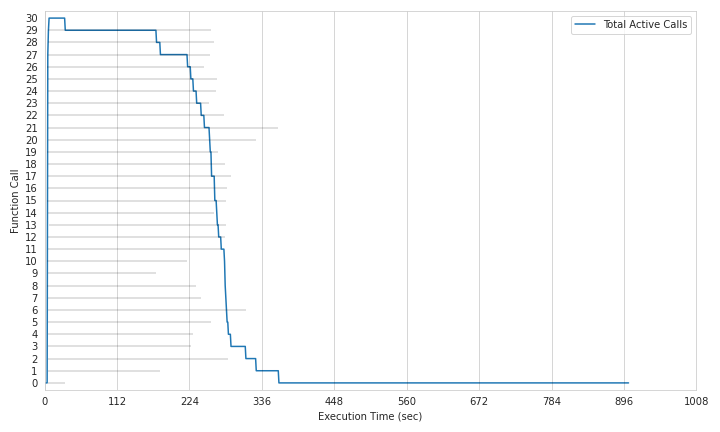

In [6]:
Image(filename="plots/calculation_histogram.png")


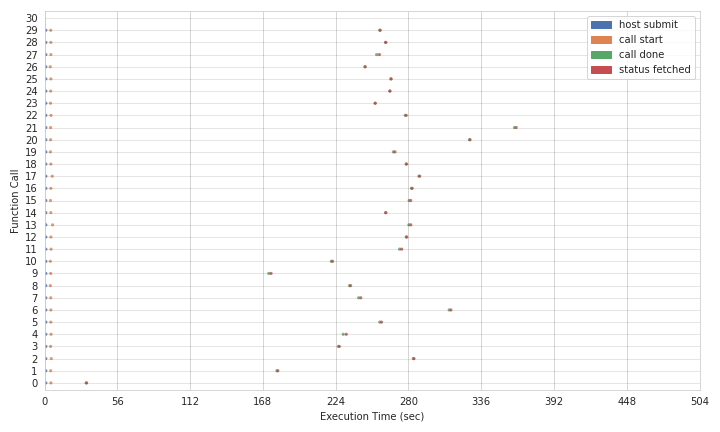

In [7]:
Image(filename="plots/calculation_timeline.png")


KPI: Cost


In [8]:
def get_process_cost(fexec):
    import pandas as pd
    df = pd.read_csv(fexec.log_path)
    cost = float(df[df["Job_ID"] == "Summary"]["Cost"])
    return cost


In [9]:
fexec.job_summary()


2021-12-03 13:08:53,905 [INFO] lithops.executors -- View log file logs at /tmp/lithops/logs/2021-12-03_13:08:53.csv


In [10]:
pd.read_csv(fexec.log_path)


,Job_ID,Function,Invocations,Memory(MB),AvgRuntime,Cost,CloudObjects
0,M000,calculation,30,122880,250.397605,0.510811,
1,Summary,,30,122880,250.397605,0.510811,0


In [11]:
cost_calculation = get_process_cost(fexec)
print(f"The experiment cost ${cost_calculation:.4f}.")


The experiment cost $0.5108.


KPI: Throughput


In [12]:
tstamps = set()
for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("tstamp"):
            tstamps.add(future.stats[key])
            
duration = max(tstamps) - min(tstamps)
print("Duration: " + str(duration) + " seconds")


Duration: 362.85576725006104 seconds


In [13]:

datos= [lidar for lidar in fexec.storage.list_keys('ziad-cloudbutton') if 'laz/' in lidar]

data_size = sum(obj["Size"] for obj in fexec.storage.list_objects('ziad-cloudbutton') if obj["Key"] in datos)
print("The size of data = {0:.2f} GB".format( data_size/1e+9))

The size of data = 1.86 GB


In [14]:
throughput_calculation = data_size / duration  # Bytes/second


In [15]:
print(f"Throughput: {throughput_calculation / 1024**2} MiB/s")


Throughput: 4.887768969499515 MiB/s


KPI: Speedup


In [16]:
BUCKET = 'ziad-cloudbutton'
COMPUTE_BACKEND = 'ibm_cf'
STORAGE_BACKEND = 'ibm_cos'
RUNTIME = 'ziad06/imagecloud:pdal100'

In [17]:
parallel_workers = [12, 24, 48, 72]
experiment_duration = dict.fromkeys(parallel_workers)


In [18]:
for option in parallel_workers:
    fexec = lithops.FunctionExecutor( backend=COMPUTE_BACKEND, storage=STORAGE_BACKEND ,runtime=RUNTIME,  max_workers=option,  log_level="DEBUG"    )
    fexec.map(calculation, data_location, runtime_memory=4096)
    fexec.get_result()
    
    tstamps = set()
    for future in fexec.futures:
        for key in future.stats.keys():
            if key.endswith("tstamp"):
                tstamps.add(future.stats[key])
    duration = max(tstamps) - min(tstamps)
    experiment_duration[option] = duration


2021-12-03 13:08:54,778 [INFO] lithops.config -- Lithops v2.5.7
2021-12-03 13:08:54,779 [DEBUG] lithops.config -- Loading configuration from /home/jovyan/work/2nd experiment/.lithops_config
2021-12-03 13:08:54,797 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2021-12-03 13:08:54,798 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2021-12-03 13:08:54,799 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2021-12-03 13:08:54,799 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.us-east.cloud-object-storage.appdomain.cloud
2021-12-03 13:08:54,800 [DEBUG] lithops.util.ibm_token_manager -- Using IBM COS API Key - Reusing Token from local cache
2021-12-03 13:08:54,802 [DEBUG] lithops.util.ibm_token_manager -- Token expiry time: 2021-12-03 14:02:47.248929+00:00 - Minutes left: 53
2021-12-03 13:08:54,806 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-eas

In [19]:
experiment_duration


{12: 793.412889957428,
 24: 467.25951051712036,
 48: 366.79153847694397,
 72: 425.7740294933319}

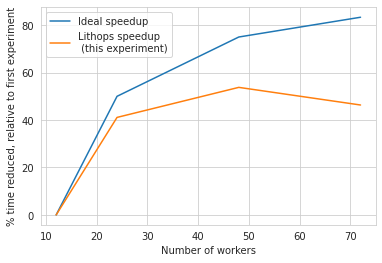

In [20]:
%matplotlib inline

duration = list(experiment_duration.values())
theoretical_best_speedup = [(1 - parallel_workers[0] / parallel_workers[i]) * 100 for i in range(0, len(parallel_workers))]
actual_speedup = [(1 - duration[i] / duration[0]) * 100 for i in range(0, len(duration))]

plt.plot(
    parallel_workers,
    theoretical_best_speedup
)
plt.plot(
    parallel_workers,
    actual_speedup
)
plt.xlabel("Number of workers")
plt.ylabel("% time reduced, relative to first experiment")
plt.legend(["Ideal speedup", "Lithops speedup\n (this experiment)"])
plt.show()

In [21]:
# list the contents of ziad-cloudbutton bucket after doing preprocessing steps
fexec.storage.list_keys('ziad-cloudbutton')


['aspect/aspect_PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_242-4424_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_242-4426_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_242-4428_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_242-4430_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_242-4432_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_242-4434_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_242-4436_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_242-4438_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_244-4428_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_244-4430_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_244-4432_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_244-4434_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_244-4436_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_244-4438_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_2017_CLM-CAS_244-4440_ORT-CLA-RGB.tif',
 'aspect/aspect_PNOA_201

###  Machine Learning - KMeans


We use clustering to group pixels together based on their similarities because we have no information about which ones belong together.

Prepare the names of data that we would train it.

prepare_data function reads fcc, chm, slope and aspect images. Then save all images in one file to use it in training step.

In [22]:
def prepare_data (obj,storage,ibm_cos):
    import rasterio as rio
    key = obj.key
    filez =key.split('/')[1].split('.')[0]
    inputfiles_fcc = f"fcc/fcc_{filez}.tif"
    inputfiles_aspect = f"aspect/aspect_{filez}.tif"
    inputfiles_slope =  f"slope/slope_{filez}.tif"
    inputfiles_chm =  f"chm/chm_{filez}.tif"

    images = [inputfiles_fcc, inputfiles_aspect, inputfiles_slope,inputfiles_chm]
    band_list= []
    for image in images:
        d= storage.get_object('ziad-cloudbutton', key=image, stream=True)
        with rio.open(d, 'r') as src:
            band = src.read(1)
            band = np.nan_to_num(band)
            band_list.append(band)


    bands_stack = np.dstack(band_list)
    width, height, depth = bands_stack.shape
    model_input = bands_stack.reshape(width * height, depth)


    a_file = open("data_train_fcc.csv", "ab+")
    np.savetxt(a_file, model_input,delimiter=';')
    a_file.close()
    return 'Done!'



In [23]:
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
itterdata= ['ziad-cloudbutton/'+lidar for lidar in fexec.storage.list_keys('ziad-cloudbutton') if 'laz/' in lidar]


2021-12-03 13:48:58,833 [INFO] lithops.config -- Lithops v2.5.7
2021-12-03 13:48:58,834 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2021-12-03 13:48:58,835 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2021-12-03 13:48:58,836 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2021-12-03 13:48:58,836 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.us-east.cloud-object-storage.appdomain.cloud
2021-12-03 13:48:58,837 [DEBUG] lithops.util.ibm_token_manager -- Using IBM COS API Key - Reusing Token from local cache
2021-12-03 13:48:58,839 [DEBUG] lithops.util.ibm_token_manager -- Token expiry time: 2021-12-03 14:02:47.248929+00:00 - Minutes left: 13
2021-12-03 13:48:58,844 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east
2021-12-03 13:48:58,845 [DEBUG] lithops.serverless.backends.ibm_cf.ibm_cf -- Creating IBM Cloud Functions client
2021-12-03 

In [24]:
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
fexec.map(prepare_data,itterdata)
fexec.get_result()


2021-12-03 13:49:10,713 [INFO] lithops.config -- Lithops v2.5.7
2021-12-03 13:49:10,715 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2021-12-03 13:49:10,716 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2021-12-03 13:49:10,717 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2021-12-03 13:49:10,718 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.us-east.cloud-object-storage.appdomain.cloud
2021-12-03 13:49:10,719 [DEBUG] lithops.util.ibm_token_manager -- Using IBM COS API Key - Reusing Token from local cache
2021-12-03 13:49:10,721 [DEBUG] lithops.util.ibm_token_manager -- Token expiry time: 2021-12-03 14:02:47.248929+00:00 - Minutes left: 13
2021-12-03 13:49:10,725 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east
2021-12-03 13:49:10,725 [DEBUG] lithops.serverless.backends.ibm_cf.ibm_cf -- Creating IBM Cloud Functions client
2021-12-03 

['Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!',
 'Done!']

In [12]:
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
for lidar in itterdata:
    fexec.call_async(prepare_data,lidar)
    fexec.get_result()




2021-12-02 10:44:15,104 [INFO] lithops.config -- Lithops v2.5.7
2021-12-02 10:44:15,113 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east
2021-12-02 10:44:15,116 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: ibm-cos_prueba
2021-12-02 10:44:15,117 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A000 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:44:16,180 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A000 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:44:16,182 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A000 - View execution logs at /tmp/lithops/logs/30d75c-3-A000.log
2021-12-02 10:44:16,184 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:44:21,365 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:44:21,375 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A001 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:44:21,527 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A001 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:44:21,528 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A001 - View execution logs at /tmp/lithops/logs/30d75c-3-A001.log
2021-12-02 10:44:21,530 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:44:43,737 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:44:43,747 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A002 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:44:44,114 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A002 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:44:44,115 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A002 - View execution logs at /tmp/lithops/logs/30d75c-3-A002.log
2021-12-02 10:44:44,116 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:45:10,339 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:45:10,349 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A003 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:45:10,529 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A003 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:45:10,530 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A003 - View execution logs at /tmp/lithops/logs/30d75c-3-A003.log
2021-12-02 10:45:10,531 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:45:34,784 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:45:34,795 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A004 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:45:35,044 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A004 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:45:35,044 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A004 - View execution logs at /tmp/lithops/logs/30d75c-3-A004.log
2021-12-02 10:45:35,046 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:45:59,249 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:45:59,258 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A005 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:45:59,506 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A005 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:45:59,507 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A005 - View execution logs at /tmp/lithops/logs/30d75c-3-A005.log
2021-12-02 10:45:59,508 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:46:23,716 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:46:23,726 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A006 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:46:23,877 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A006 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:46:23,877 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A006 - View execution logs at /tmp/lithops/logs/30d75c-3-A006.log
2021-12-02 10:46:23,879 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:46:48,094 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:46:48,103 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A007 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:46:48,372 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A007 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:46:48,373 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A007 - View execution logs at /tmp/lithops/logs/30d75c-3-A007.log
2021-12-02 10:46:48,374 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:47:14,584 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:47:14,592 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A008 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:47:15,230 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A008 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:47:15,231 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A008 - View execution logs at /tmp/lithops/logs/30d75c-3-A008.log
2021-12-02 10:47:15,232 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:47:38,459 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:47:38,468 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A009 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:47:38,696 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A009 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:47:38,697 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A009 - View execution logs at /tmp/lithops/logs/30d75c-3-A009.log
2021-12-02 10:47:38,699 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:48:02,904 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:48:02,913 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A010 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:48:03,148 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A010 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:48:03,149 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A010 - View execution logs at /tmp/lithops/logs/30d75c-3-A010.log
2021-12-02 10:48:03,151 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:48:27,358 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:48:27,366 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A011 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:48:27,600 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A011 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:48:27,601 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A011 - View execution logs at /tmp/lithops/logs/30d75c-3-A011.log
2021-12-02 10:48:27,603 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:48:51,818 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:48:51,841 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A012 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:48:52,079 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A012 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:48:52,079 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A012 - View execution logs at /tmp/lithops/logs/30d75c-3-A012.log
2021-12-02 10:48:52,082 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:49:15,287 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:49:15,295 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A013 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:49:15,562 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A013 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:49:15,563 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A013 - View execution logs at /tmp/lithops/logs/30d75c-3-A013.log
2021-12-02 10:49:15,564 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:49:39,829 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:49:39,841 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A014 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:49:40,104 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A014 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:49:40,105 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A014 - View execution logs at /tmp/lithops/logs/30d75c-3-A014.log
2021-12-02 10:49:40,107 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:50:04,321 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:50:04,331 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A015 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:50:04,561 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A015 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:50:04,562 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A015 - View execution logs at /tmp/lithops/logs/30d75c-3-A015.log
2021-12-02 10:50:04,564 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:50:30,825 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:50:30,834 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A016 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:50:31,064 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A016 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:50:31,065 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A016 - View execution logs at /tmp/lithops/logs/30d75c-3-A016.log
2021-12-02 10:50:31,066 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:50:55,325 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:50:55,343 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A017 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:50:55,506 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A017 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:50:55,507 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A017 - View execution logs at /tmp/lithops/logs/30d75c-3-A017.log
2021-12-02 10:50:55,509 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:51:21,723 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:51:21,732 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A018 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:51:22,001 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A018 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:51:22,001 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A018 - View execution logs at /tmp/lithops/logs/30d75c-3-A018.log
2021-12-02 10:51:22,003 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:51:46,242 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:51:46,251 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A019 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:51:46,499 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A019 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:51:46,500 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A019 - View execution logs at /tmp/lithops/logs/30d75c-3-A019.log
2021-12-02 10:51:46,501 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:52:12,729 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:52:12,738 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A020 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:52:12,971 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A020 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:52:12,971 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A020 - View execution logs at /tmp/lithops/logs/30d75c-3-A020.log
2021-12-02 10:52:12,972 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:52:39,183 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:52:39,191 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A021 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:52:39,353 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A021 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:52:39,353 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A021 - View execution logs at /tmp/lithops/logs/30d75c-3-A021.log
2021-12-02 10:52:39,355 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:53:05,597 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:53:05,606 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A022 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:53:05,760 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A022 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:53:05,760 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A022 - View execution logs at /tmp/lithops/logs/30d75c-3-A022.log
2021-12-02 10:53:05,761 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:53:31,974 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:53:31,983 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A023 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:53:32,160 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A023 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:53:32,160 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A023 - View execution logs at /tmp/lithops/logs/30d75c-3-A023.log
2021-12-02 10:53:32,162 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:53:58,381 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:53:58,391 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A024 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:53:58,548 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A024 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:53:58,549 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A024 - View execution logs at /tmp/lithops/logs/30d75c-3-A024.log
2021-12-02 10:53:58,550 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:54:22,790 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:54:22,800 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A025 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:54:22,956 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A025 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:54:22,956 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A025 - View execution logs at /tmp/lithops/logs/30d75c-3-A025.log
2021-12-02 10:54:22,958 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:54:47,208 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:54:47,216 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A026 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:54:47,443 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A026 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:54:47,444 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A026 - View execution logs at /tmp/lithops/logs/30d75c-3-A026.log
2021-12-02 10:54:47,446 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:55:11,676 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:55:11,686 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A027 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:55:11,840 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A027 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:55:11,840 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A027 - View execution logs at /tmp/lithops/logs/30d75c-3-A027.log
2021-12-02 10:55:11,841 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:55:38,056 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:55:38,065 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A028 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:55:38,274 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A028 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:55:38,275 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A028 - View execution logs at /tmp/lithops/logs/30d75c-3-A028.log
2021-12-02 10:55:38,277 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:56:02,499 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data
2021-12-02 10:56:02,508 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A029 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB


2021-12-02 10:56:02,744 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A029 - Starting function invocation: prepare_data() - Total: 1 activations
2021-12-02 10:56:02,745 [INFO] lithops.invokers -- ExecutorID 30d75c-3 | JobID A029 - View execution logs at /tmp/lithops/logs/30d75c-3-A029.log
2021-12-02 10:56:02,747 [INFO] lithops.wait -- ExecutorID 30d75c-3 - Getting results from functions


2021-12-02 10:56:29,013 [INFO] lithops.executors -- ExecutorID 30d75c-3 - Cleaning temporary data


KPIs 

2021-12-03 13:50:57,209 [INFO] lithops.executors -- ExecutorID 5f0787-6 - Creating execution plots


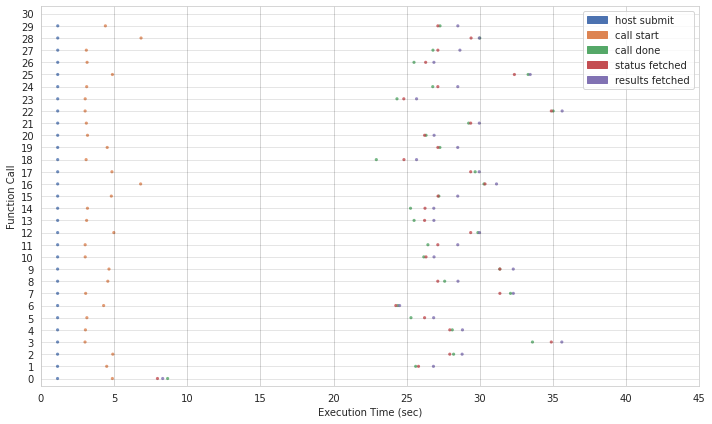

In [25]:
fexec.plot(dst="plots/prepare_data")


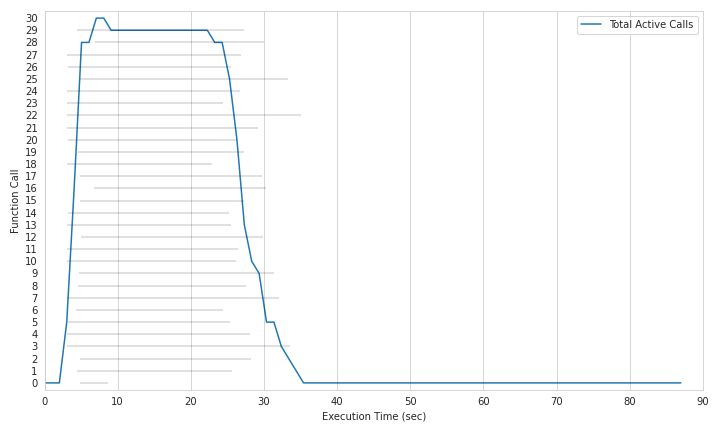

In [26]:
Image(filename="plots/prepare_data_histogram.png")


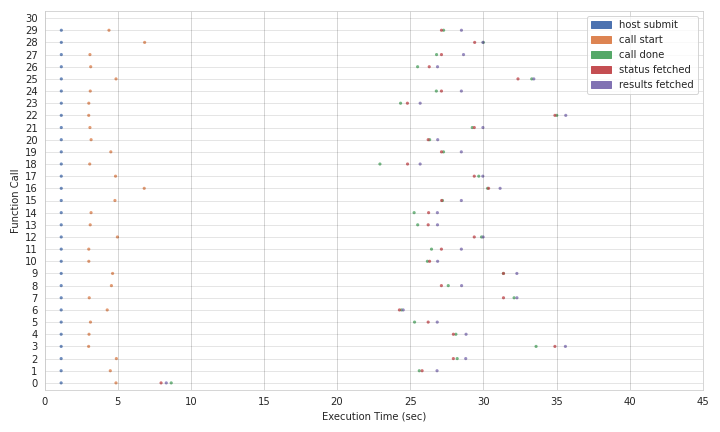

In [27]:
Image(filename="plots/prepare_data_timeline.png")


KPI: Cost


In [28]:
fexec.job_summary()


2021-12-03 13:51:03,895 [INFO] lithops.executors -- View log file logs at /tmp/lithops/logs/2021-12-03_13:51:03.csv


In [29]:
pd.read_csv(fexec.log_path)


,Job_ID,Function,Invocations,Memory(MB),AvgRuntime,Cost,CloudObjects
0,M000,prepare_data,30,122880,23.362404,0.047659,
1,Summary,,30,122880,23.362404,0.047659,0


In [30]:
cost_prepare_data = get_process_cost(fexec)
print(f"The experiment cost ${cost_prepare_data:.4f}.")


The experiment cost $0.0477.


KPI: Throughput


In [31]:
tstamps = set()
for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("tstamp"):
            tstamps.add(future.stats[key])
            
duration = max(tstamps) - min(tstamps)
print("Duration: " + str(duration) + " seconds")


Duration: 35.629520416259766 seconds


In [46]:
datos= [lidar for lidar in fexec.storage.list_keys('ziad-cloudbutton') if ('chm' in lidar) or ('aspect' in lidar) or ('slope' in lidar) or ('fcc/fcc' in lidar)]

In [47]:

data_size = sum(obj["Size"] for obj in fexec.storage.list_objects('ziad-cloudbutton') if obj["Key"] in datos)
print("The size of data = {0:.2f} GB".format( data_size/1e+9))

The size of data = 2.80 GB


In [48]:
throughput_prepare_data = data_size / duration  # Bytes/second


In [49]:
print(f"Throughput: {throughput_prepare_data / 1024**2} MiB/s")


Throughput: 74.85736319822185 MiB/s


KPI: Speedup


In [50]:
BUCKET = 'ziad-cloudbutton'
COMPUTE_BACKEND = 'ibm_cf'
STORAGE_BACKEND = 'ibm_cos'
RUNTIME = 'ziad06/imagecloud:pdal100'
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096)


2021-12-03 13:54:31,312 [INFO] lithops.config -- Lithops v2.5.7
2021-12-03 13:54:31,313 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2021-12-03 13:54:31,314 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2021-12-03 13:54:31,315 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2021-12-03 13:54:31,316 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.us-east.cloud-object-storage.appdomain.cloud
2021-12-03 13:54:31,316 [DEBUG] lithops.util.ibm_token_manager -- Using IBM COS API Key - Reusing Token from local cache
2021-12-03 13:54:31,318 [DEBUG] lithops.util.ibm_token_manager -- Token expiry time: 2021-12-03 14:02:47.248929+00:00 - Minutes left: 8
2021-12-03 13:54:31,323 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east
2021-12-03 13:54:31,324 [DEBUG] lithops.serverless.backends.ibm_cf.ibm_cf -- Creating IBM Cloud Functions client
2021-12-03 1

In [51]:
parallel_workers = [12, 24, 48, 72]
experiment_duration = dict.fromkeys(parallel_workers)


In [52]:
for option in parallel_workers:
    fexec = lithops.FunctionExecutor(
        backend=COMPUTE_BACKEND, 
        storage=STORAGE_BACKEND,
        runtime=RUNTIME,
        max_workers=option, # Tells lithops to work w/only this number of concurrent workers
        log_level="DEBUG"
    )
    fexec.map(
        prepare_data, itterdata,  runtime_memory=4096
    )
    fexec.get_result()
    
    tstamps = set()
    for future in fexec.futures:
        for key in future.stats.keys():
            if key.endswith("tstamp"):
                tstamps.add(future.stats[key])
    duration = max(tstamps) - min(tstamps)
    experiment_duration[option] = duration


2021-12-03 13:54:34,540 [INFO] lithops.config -- Lithops v2.5.7
2021-12-03 13:54:34,542 [DEBUG] lithops.config -- Loading configuration from /home/jovyan/work/2nd experiment/.lithops_config
2021-12-03 13:54:34,548 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2021-12-03 13:54:34,549 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2021-12-03 13:54:34,550 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2021-12-03 13:54:34,551 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.us-east.cloud-object-storage.appdomain.cloud
2021-12-03 13:54:34,551 [DEBUG] lithops.util.ibm_token_manager -- Using IBM COS API Key - Reusing Token from local cache
2021-12-03 13:54:34,553 [DEBUG] lithops.util.ibm_token_manager -- Token expiry time: 2021-12-03 14:02:47.248929+00:00 - Minutes left: 8
2021-12-03 13:54:34,557 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east

In [53]:
experiment_duration


{12: 80.42422294616699,
 24: 50.744956970214844,
 48: 32.532307386398315,
 72: 34.11360144615173}

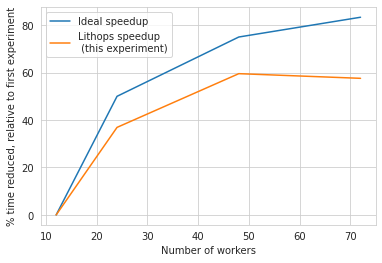

In [54]:
duration = list(experiment_duration.values())
theoretical_best_speedup = [(1 - parallel_workers[0] / parallel_workers[i]) * 100 for i in range(0, len(parallel_workers))]
actual_speedup = [(1 - duration[i] / duration[0]) * 100 for i in range(0, len(duration))]

plt.plot(
    parallel_workers,
    theoretical_best_speedup
)
plt.plot(
    parallel_workers,
    actual_speedup
)
plt.xlabel("Number of workers")
plt.ylabel("% time reduced, relative to first experiment")
plt.legend(["Ideal speedup", "Lithops speedup\n (this experiment)"])


upload_file function uploads the file which was created above to IBM cloud

In [55]:
# upload csv file to ibm cloud
def upload_file(obj , ibm_cos):
    dir_name = os.getcwd()
    test = os.listdir(dir_name)
    for item in test:
        if item.endswith(".csv"):
            ibm_cos.upload_file(Bucket ='ziad-cloudbutton', Filename = 'data_train_fcc.csv',Key  = 'data_train_fcc.csv')
            return 'Done'



In [13]:
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
fexec.map(upload_file, 'ziad-cloudbutton/txt/')
fexec.get_result()


2021-12-02 10:58:05,440 [INFO] lithops.config -- Lithops v2.5.7
2021-12-02 10:58:05,448 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east
2021-12-02 10:58:05,452 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: ibm-cos_prueba
2021-12-02 10:58:05,453 [INFO] lithops.invokers -- ExecutorID 30d75c-4 | JobID M000 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 10:58:06,504 [INFO] lithops.invokers -- ExecutorID 30d75c-4 | JobID M000 - Starting function invocation: upload_file() - Total: 1 activations
2021-12-02 10:58:06,511 [INFO] lithops.invokers -- ExecutorID 30d75c-4 | JobID M000 - View execution logs at /tmp/lithops/logs/30d75c-4-M000.log
2021-12-02 10:58:06,517 [INFO] lithops.wait -- ExecutorID 30d75c-4 - Getting results from functions


2021-12-02 11:03:12,175 [INFO] lithops.executors -- ExecutorID 30d75c-4 - Cleaning temporary data


['Done']

delete_file function delete the file which was created to save memory

In [15]:
# Delete csv file
def delete_file(obj, storage):
    dir_name = os.getcwd()
    test = os.listdir(dir_name)
    for item in test:
        if item.endswith(".csv"):
             os.remove(os.path.join(dir_name, item))
    return 'Done!'




fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
fexec.map(delete_file, 'ziad-cloudbutton/txt/')
fexec.wait()


        

2021-12-02 11:06:34,779 [INFO] lithops.config -- Lithops v2.5.7
2021-12-02 11:06:34,786 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east
2021-12-02 11:06:34,789 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: ibm-cos_prueba
2021-12-02 11:06:34,790 [INFO] lithops.invokers -- ExecutorID 30d75c-6 | JobID M000 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB
2021-12-02 11:06:35,850 [INFO] lithops.invokers -- ExecutorID 30d75c-6 | JobID M000 - Starting function invocation: delete_file() - Total: 1 activations
2021-12-02 11:06:35,853 [INFO] lithops.invokers -- ExecutorID 30d75c-6 | JobID M000 - View execution logs at /tmp/lithops/logs/30d75c-6-M000.log
2021-12-02 11:06:35,856 [INFO] lithops.wait -- ExecutorID 30d75c-6 - Waiting for 100% of functions to complete


([<lithops.future.ResponseFuture at 0x7faff4755c40>], [])

In [56]:
# check if the directory is empty
def check_file(obj , storage):
    # check if the file it delete correctly
        dir_name = os.getcwd()
        test = os.listdir(dir_name)
        return test

            
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
fexec.map(check_file, 'ziad-cloudbutton/txt/')
rsults=fexec.get_result()
rsults



2021-12-03 14:03:20,624 [INFO] lithops.config -- Lithops v2.5.7
2021-12-03 14:03:20,625 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2021-12-03 14:03:20,626 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2021-12-03 14:03:20,627 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2021-12-03 14:03:20,627 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.us-east.cloud-object-storage.appdomain.cloud
2021-12-03 14:03:20,628 [DEBUG] lithops.util.ibm_token_manager -- Using IBM COS API Key - Reusing Token from local cache
2021-12-03 14:03:20,631 [DEBUG] lithops.util.ibm_token_manager -- Token expiry time: 2021-12-03 14:02:47.248929+00:00 - Minutes left: 0
2021-12-03 14:03:20,632 [DEBUG] lithops.util.ibm_token_manager -- Token expired. Requesting new token
2021-12-03 14:03:21,115 [DEBUG] lithops.util.ibm_token_manager -- Token expiry time: 2021-12-03 15:03:21.113423+00:00 - Minutes left: 59
20

[['data_train_fcc1.csv', 'lithops', '__main__.py']]

In [4]:
# Read the train data file
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
data =  fexec.storage.get_object('ziad-cloudbutton', key='data_train_fcc.csv', stream=True)
X_train= pd.read_csv(data,delimiter=';')
X_train.shape

Lithops v2.2.3 init for IBM Cloud Functions - Namespace: ibm-cos_prueba - Region: us_east


(120468407, 4)

# Read the train data file
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
data =  fexec.storage.get_object('ziad-cloudbutton', key='data_train_fcc.csv', stream=True)
X_train= pd.read_csv(data,delimiter=';',nrows=70000000)
X_train.shape

no_of_ranges =  np.arange(3, 11, 1)
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
models = []
predicted = []
inertia_vals = []
s_scores = []
for n_clust in no_of_ranges:
    kmeans = KMeans(n_clusters=n_clust,**kmeans_kwargs)
    y_pred =kmeans.fit_predict(X_train)

    # Append model
    models.append(kmeans)

    # Calculate metrics
    s_scores.append(silhouette_score(X_train, y_pred, sample_size=1000))
    #inertia_vals.append(pipe.inertia_)
    inertia_vals.append(kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(no_of_ranges, s_scores, marker='o')
ax.set_title("Silhouette scores")
ax.set_xlabel('Number of clusters')


fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(no_of_ranges, inertia_vals, marker='o')
ax.set_title("'Inertia of the models")
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Intra-cluster (inertia)');


In [20]:
def kmeans (obj,storage,ibm_cos):
    data =  storage.get_object('ziad-cloudbutton', key='data_train_fcc.csv', stream=True)
    X_train= pd.read_csv(data,delimiter=';',nrows=15000000)

    no_of_ranges =  np.arange(3, 11, 1)
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
    models = []
    predicted = []
    inertia_vals = []
    s_scores = []
    for n_clust in no_of_ranges:
        kmeans = KMeans(n_clusters=n_clust,**kmeans_kwargs)
        y_pred =kmeans.fit_predict(X_train)

        # Append model
        models.append(kmeans)

        # Calculate metrics
        s_scores.append(silhouette_score(X_train, y_pred, sample_size=1000))
        #inertia_vals.append(pipe.inertia_)
        inertia_vals.append(kmeans.inertia_)
    final = [no_of_ranges, s_scores ,inertia_vals]
    return (final)    
    
    

In [22]:
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
fexec.map(kmeans, 'ziad-cloudbutton/txt/')
result=fexec.get_result()


Lithops v2.2.3 init for IBM Cloud Functions - Namespace: ibm-cos_prueba - Region: us_east
ExecutorID 472066/6 | JobID M000 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB 
ExecutorID 472066/6 | JobID M000 - Uploading function and data - Total: 1.5KiB
ExecutorID 472066/6 | JobID M000 - Starting function invocation: kmeans() - Total: 1 activations
ExecutorID 472066/6 - Getting results...



ExecutorID 472066/6 - Cleaning temporary data


In [31]:
no_of_ranges = result[0][0]
s_scores = result[0][1]
inertia_vals = result[0][2]

Text(0.5, 0, 'Number of clusters')

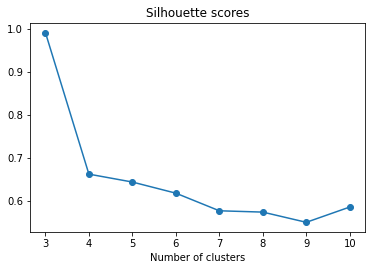

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(no_of_ranges, s_scores, marker='o')
ax.set_title("Silhouette scores")
ax.set_xlabel('Number of clusters')


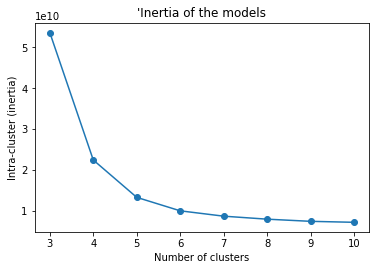

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(no_of_ranges, inertia_vals, marker='o')
ax.set_title("'Inertia of the models")
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Intra-cluster (inertia)');


The number of clusters (k) is the most important hyperparameter in K-Means clustering. So to find the optimal value of k we apply Elbow method and Silhouette method.

Elbow method finds the optimal number of clusters,  then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.

The second graph reprsents Silhouette score. The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster.

We can notice the number of clusters 5 is matching in both methods.

Now, we train the model another time using the value 5 as number of clusters.

In [106]:
def train_kmeans(obj,storage,ibm_cos):
    data =  storage.get_object('ziad-cloudbutton', key='data_train_fcc.csv', stream=True)
    X_train= pd.read_csv(data,delimiter=';',nrows=15000000)
    no_of_ranges =  np.arange(3, 11, 1)
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
    kmeans = KMeans(n_clusters=5,**kmeans_kwargs)
    y_pred =kmeans.fit_predict(X_train)
    model = kmeans
    bufmodel  = io.BytesIO()
    joblib.dump(model, bufmodel)
    bufmodel.seek(0)  # Without this line it fails
    return model
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096 )
fexec.map(train_kmeans, 'ziad-cloudbutton/txt/')
kmeans=fexec.get_result()


Lithops v2.2.3 init for IBM Cloud Functions - Namespace: ibm-cos_prueba - Region: us_east
ExecutorID 472066/16 | JobID M000 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB 
ExecutorID 472066/16 | JobID M000 - Uploading function and data - Total: 1.3KiB
ExecutorID 472066/16 | JobID M000 - Starting function invocation: train_kmeans() - Total: 1 activations
ExecutorID 472066/16 - Getting results...



ExecutorID 472066/16 - Cleaning temporary data


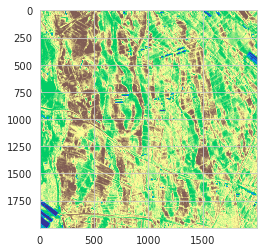

In [51]:
name = 'PNOA_2017_CLM-CAS_244-4452_ORT-CLA-RGB.tif'
aspect = 'aspect/aspect_'+name
slop = 'slop/slop_'+name
chm = 'chm/chm_'+name
fcc = 'fcc/fcc_'+name
raster_fns = [fcc, aspect,slop,chm]
band_list = []
for image in raster_fns:
    with rio.open(image, 'r') as src:
        band = src.read(1)
        band = np.nan_to_num(band)
        band_list.append(band)
bands_stack = np.dstack(band_list)
width, height, depth = bands_stack.shape
model_input = bands_stack.reshape(width * height, depth)
#model_input_scaled = scale(model_input)
#model_input_scaled = scaler.transform(model_input)
y_pred = kmeans.predict(model_input)
quantized_raster = np.reshape(y_pred, (width, height))
plt.imshow(quantized_raster, cmap="terrain")


###  Export and import  trained model 

Save the **Machine Learning model** based in KMeans through <i>joblib</i> and import it. By doing so we will be able to upload it to IBM_COS. 


In [55]:
bufmodel  = io.BytesIO()
joblib.dump(kmeans[0], bufmodel)
bufmodel.seek(0)  # Without this line it fails
fexec.storage.put_object('ziad-cloudbutton', key= 'trained_model/kmeans1.sav',data= bufmodel)

2021-11-30 12:22:52,284 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- PUT Object trained_model/kmeans.sav OK


True

In [111]:
def map_classification(obj,storage , ibm_cos):
    key = obj.key
    filez =key.split('/')[1].split('.')[0]
    inputfiles_fcc = f"fcc/fcc_{filez}.tif"
    inputfiles_aspect = f"aspect/aspect_{filez}.tif"
    inputfiles_slope =  f"slope/slope_{filez}.tif"
    inputfiles_chm =  f"chm/chm_{filez}.tif"

    images = [inputfiles_fcc, inputfiles_aspect, inputfiles_slope,inputfiles_chm]
    band_list= []
    for image in images:
        d= storage.get_object('ziad-cloudbutton', key=image, stream=True)
        with rio.open(d, 'r') as src:
            band = src.read(1)
            band = np.nan_to_num(band)
            band_list.append(band)


    bands_stack = np.dstack(band_list)
    width, height, depth = bands_stack.shape
    model_input = bands_stack.reshape(width * height, depth)
    shapefile = storage.get_object('ziad-cloudbutton', key='trained_model/kmeans1.sav')
    loaded_model = joblib.load(io.BytesIO(shapefile)) 
    prediction = loaded_model.predict(model_input)  # for each pixel of our we perform a prediction
    quantized_raster = np.reshape(prediction, (width, height))
    return  quantized_raster

In [112]:
data_location = 'ziad-cloudbutton/test/'
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096)
fexec.call_async(map_classification, data_location)
results = fexec.get_result()


Lithops v2.2.3 init for IBM Cloud Functions - Namespace: ibm-cos_prueba - Region: us_east
ExecutorID 472066/17 | JobID A000 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB 
ExecutorID 472066/17 | JobID A000 - Uploading function and data - Total: 3.8KiB
ExecutorID 472066/17 | JobID A000 - Starting function invocation: map_classification() - Total: 11 activations
ExecutorID 472066/17 - Getting results...



ExecutorID 472066/17 - Cleaning temporary data


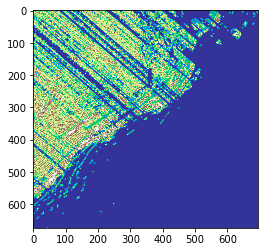

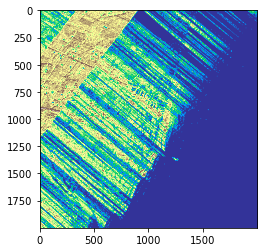

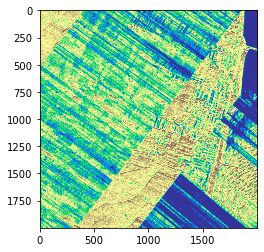

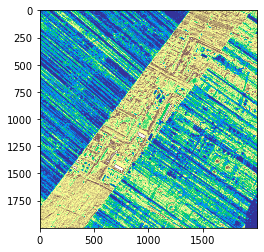

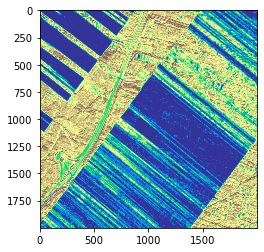

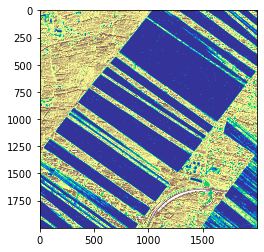

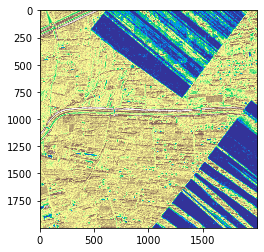

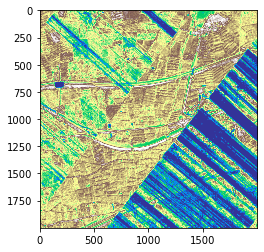

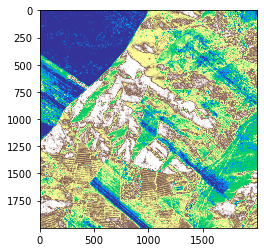

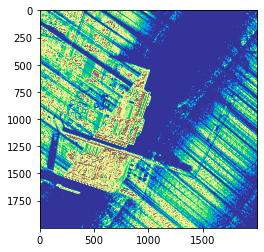

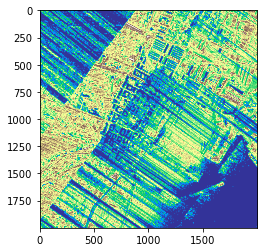

In [113]:
for img in results:
    show(img, cmap='terrain')

KPIs 

In [ ]:
fexec.plot(dst="plots/map_classification")


In [ ]:
Image(filename="plots/map_classification_histogram.png")


In [ ]:
Image(filename="plots/map_classification_timeline.png")


KPI: Cost


In [ ]:
fexec.job_summary()


In [ ]:
pd.read_csv(fexec.log_path)


In [ ]:
cost_interpolation = get_process_cost(fexec)
print(f"The experiment cost ${cost_interpolation:.4f}.")


KPI: Throughput


In [ ]:
tstamps = set()
for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("tstamp"):
            tstamps.add(future.stats[key])
            
duration = max(tstamps) - min(tstamps)
print("Duration: " + str(duration) + " seconds")


In [ ]:
throughput_interpolation = data_size / duration  # Bytes/second


In [ ]:
print(f"Throughput: {throughput_interpolation / 1024**2} MiB/s")


KPI: Speedup


In [ ]:
BUCKET = 'ziad-cloudbutton'
COMPUTE_BACKEND = 'ibm_cf'
STORAGE_BACKEND = 'ibm_cos'
RUNTIME = 'ziad06/imagecloud:pdal100'
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096)


In [ ]:
parallel_workers = [12, 24, 48, 72]
experiment_duration = dict.fromkeys(parallel_workers)


In [ ]:
for option in parallel_workers:
    fexec = lithops.FunctionExecutor(backend=COMPUTE_BACKEND, storage=STORAGE_BACKEND,runtime=RUNTIME, max_workers=option,log_level="DEBUG")
    fexec.map( map_classification, data_location, runtime_memory=4096)
    fexec.get_result()
    
    tstamps = set()
    for future in fexec.futures:
        for key in future.stats.keys():
            if key.endswith("tstamp"):
                tstamps.add(future.stats[key])
    duration = max(tstamps) - min(tstamps)
    experiment_duration[option] = duration


In [ ]:
experiment_duration


In [ ]:

duration = list(experiment_duration.values())
theoretical_best_speedup = [(1 - parallel_workers[0] / parallel_workers[i]) * 100 for i in range(0, len(parallel_workers))]
actual_speedup = [(1 - duration[i] / duration[0]) * 100 for i in range(0, len(duration))]

plt.plot( parallel_workers,  theoretical_best_speedup)
plt.plot(  parallel_workers,  actual_speedup)
plt.xlabel("Number of workers")
plt.ylabel("% time reduced, relative to first experiment")
plt.legend(["Ideal speedup", "Lithops speedup\n (this experiment)"])


In [ ]:
data_location = 'ziad-cloudbutton/test/'
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096)
fexec.call_async(map_classification, data_location)
results = fexec.get_result()


In [ ]:
for img in results:
    show(img, cmap='terrain')


In [ ]:
import session_info
session_info.show(html=False)
